# 💰 Hacking the "Mega da Virada" with Data Science
<sub>By Juan Penas

<sub>In Portuguese [here](https://github.com/jhpenas/mega_sena/blob/main/mega-sena%20pt.ipynb).</sub>

<sub>[More Projects](https://github.com/jhpenas/portfolio).</sub>

Every end of the year, millions of Brazilians try their luck in the **Mega da Virada** (New Year's Eve Draw). But is there any logic behind the balls? Or is it all chaos and randomness?

As a Data Scientist, I decided not to rely on intuition. I downloaded the history of all draws and used Python to answer:

- Are there "biased numbers"?
- Does the New Year's Draw behave differently from regular draws?
- If I spent R$ 300k randomly, what would be my loss?

## 📋 Executive Summary (TL;DR)

For those in a hurry, here are the 3 fundamental findings of this analysis:

1.  **🚨 The Statistical Anomaly:** Contrary to the common sense of "perfect randomness", the Chi-Square Test revealed a **p-value of 0.04**. This indicates a statistical anomaly: historically, some numbers deviate significantly from the expected frequency (Outliers).
2.  **✨ The Myth of the Turn:** The analysis proved that the "Mega da Virada" holds no special statistical characteristics. The average sum of the drawn numbers is virtually identical to regular draws (**183.09** vs **183.23**).
3.  **💸 The Financial Reality:** We tried to exploit the statistical anomaly using a Monte Carlo Simulation with 50,000 games based on "hot numbers". The result was a **negative ROI of ~99%**. The pattern exists, but it is not enough to overcome the house edge.

## 🗺️ Analysis Roadmap

In this notebook, we will go through the following technical steps:

* **ETL and Cleaning:** Collection and processing of raw data from Caixa Econômica Federal (1996–Today).
* **Feature Engineering:** Transformation of draws into binary vectors (**Multi-Hot Encoding**) for proper computational analysis.
* **Visual Analysis:** Heatmaps to understand ticket geometry and Correlation Matrices.
* **Hypothesis Testing:** Application of the **Chi-Square ($\chi^2$)** test to validate randomness and **Residual Analysis** to identify which numbers cause deviations.
* **Profile Comparison:** Comparative study between regular draws and special New Year editions.
* **Monte Carlo Simulation:** Using computational brute force to test the economic viability of betting strategies.

## 1. Import and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Configuração visual
sns.set_theme(style="whitegrid")
sns.set_palette("YlGn_r")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. ETL and Preparation

The raw material for this study is the complete history of the Mega Sena, extracted from the [official website](https://loterias.caixa.gov.br/Paginas/Mega-Sena.aspx) of Caixa Econômica Federal. The dataset covers nearly three decades of draws (1996–Present), providing us with a robust sample universe to apply long-term statistical tests and validate the Law of Large Numbers.

In [3]:
# Carregar dataset
df_mega_sena = pd.read_excel('Mega-Sena.xlsx')

In [4]:
colunas_dezenas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']

In [5]:
# Converter Data
df_mega_sena['Data do Sorteio'] = pd.to_datetime(df_mega_sena['Data do Sorteio'], format='%d/%m/%Y')

In [6]:
for col in colunas_dezenas:
    # Remove possíveis erros de string/espaços e converte para int
    df_mega_sena[col] = pd.to_numeric(df_mega_sena[col], errors='coerce').fillna(0).astype(int)

In [7]:
# Ordenando linha a linha (Bola 1 sempre a menor, Bola 6 sempre a maior)
df_mega_sena[colunas_dezenas] = np.sort(df_mega_sena[colunas_dezenas].values, axis=1)

In [8]:
print(f"Dataset pronto: {df_mega_sena.shape[0]} concursos carregados.")

Dataset pronto: 2954 concursos carregados.


In [9]:
df_mega_sena.head()

,Concurso,Data do Sorteio,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Ganhadores 6 acertos,Cidade / UF,Rateio 6 acertos,Ganhadores 5 acertos,Rateio 5 acertos,Ganhadores 4 acertos,Rateio 4 acertos,Acumulado 6 acertos,Arrecadação Total,Estimativa prêmio,Acumulado Sorteio Especial Mega da Virada,Observação
0,1,1996-03-11,4,5,30,33,41,52,0,NaN,"R$0,00",17,"R$39.158,92",2016,"R$330,21","R$1.714.650,23","R$0,00","R$0,00","R$0,00",NaN
1,2,1996-03-18,9,37,39,41,43,49,1,PR,"R$2.307.162,23",65,"R$14.424,02",4488,"R$208,91","R$0,00","R$0,00","R$0,00","R$0,00",NaN
2,3,1996-03-25,10,11,29,30,36,47,2,RN; SP,"R$391.192,51",62,"R$10.515,93",4261,"R$153,01","R$0,00","R$0,00","R$0,00","R$0,00",NaN
3,4,1996-04-01,1,5,6,27,42,59,0,NaN,"R$0,00",39,"R$15.322,24",3311,"R$180,48","R$717.080,75","R$0,00","R$0,00","R$0,00",NaN
4,5,1996-04-08,1,2,6,16,19,46,0,NaN,"R$0,00",98,"R$5.318,10",5399,"R$96,53","R$1.342.488,85","R$0,00","R$0,00","R$0,00",NaN


Dataset loaded successfully. The numbers were sorted and converted to integers. We have a robust historical base to statistically validate any hypothesis.

## 3. Feature Engineering: Categorical Approach

A common mistake when trying to use Machine Learning in lotteries is treating the balls as numeric values (Regression). Mathematically, ball 60 is not worth "60 times more" than ball 1; they are just different symbols, like Apple and Banana.

To fix this and avoid model bias, we apply the Multi-Hot Encoding technique. We transform each draw into a binary vector of 60 positions (0 or 1). This allows us to analyze the presence of each number without confusing magnitude with importance.

In [10]:
# Prepara lista de listas
lista_jogos = df_mega_sena[colunas_dezenas].values.tolist()

# Binarizador
mlb = MultiLabelBinarizer(classes=range(1, 61))
matriz_binaria = mlb.fit_transform(lista_jogos)

# Cria dataframe Multi-Hot (útil para correlação e ML)
df_multi_hot = pd.DataFrame(matriz_binaria, columns=[f'Num_{i}' for i in range(1, 61)])

print(f"Example: Draw 0 became the vector:\n{df_multi_hot.iloc[0].values}")

Example: Draw 0 became the vector:
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Now, each draw is a row with 60 binary columns. This allows us to calculate correlations and use association rule algorithms. The computer now "understands" the game.

## 4. Visualization 1: Ticket Heatmap

The Geography of Luck: They say we should spread the numbers across the ticket. Let's visualize the historical frequency projected onto the physical 6x10 matrix of the ticket. Where are the hot zones?

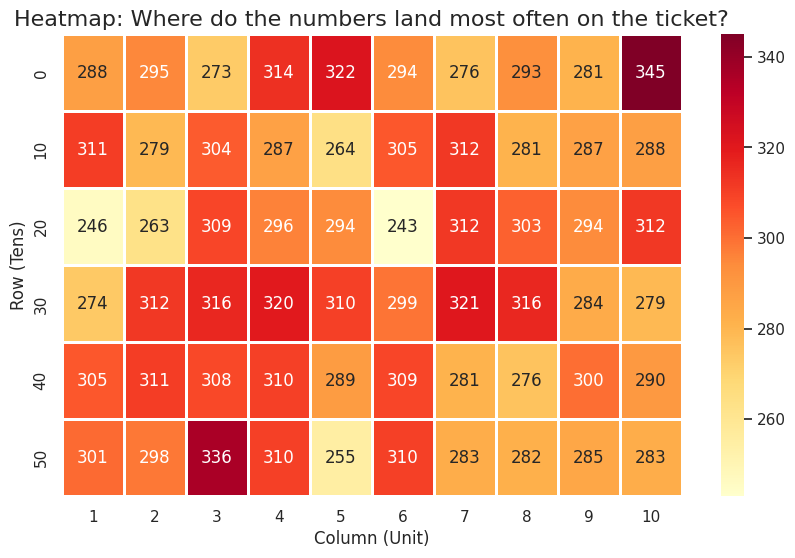

In [11]:
# Contagem total de cada número
frequencia_total = df_multi_hot.sum().values

# Criar matriz 6x10 (formato do volante)
volante = np.zeros((6, 10))

for num in range(1, 61):
    freq = frequencia_total[num-1] # Ajuste de índice (0-59 para números 1-60)
    linha = (num - 1) // 10
    coluna = (num - 1) % 10
    volante[linha, coluna] = freq

plt.figure(figsize=(10, 6))
sns.heatmap(volante, annot=True, fmt='.0f', cmap="YlOrRd", linewidths=1, linecolor='white',
            xticklabels=range(1, 11), yticklabels=range(0, 60, 10))

plt.title('Heatmap: Where do the numbers land most often on the ticket?', fontsize=16)
plt.xlabel('Column (Unit)', fontsize=12)
plt.ylabel('Row (Tens)', fontsize=12)
plt.show()

The chart shows a distribution that tends toward uniformity. Although some points seem hotter (darker colors), this is generally the result of natural variance. There are no holes in the ticket where luck never lands, nor guaranteed islands.

## 5. Visualization 2: Correlation Matrix

Now that we have vectorized the draws, we can calculate the correlation between the numbers. Does the number 12 tend to appear whenever the number 5 is drawn?

In this correlation matrix, we look for points of intense color. In a perfectly random system, we expect a mostly "gray" map (zero correlation). Any strong deviation here would be an indication of a statistical anomaly... or just a rare coincidence.

In [12]:
# Calculando a correlação entre a presença dos números
correlacao = df_multi_hot.corr()

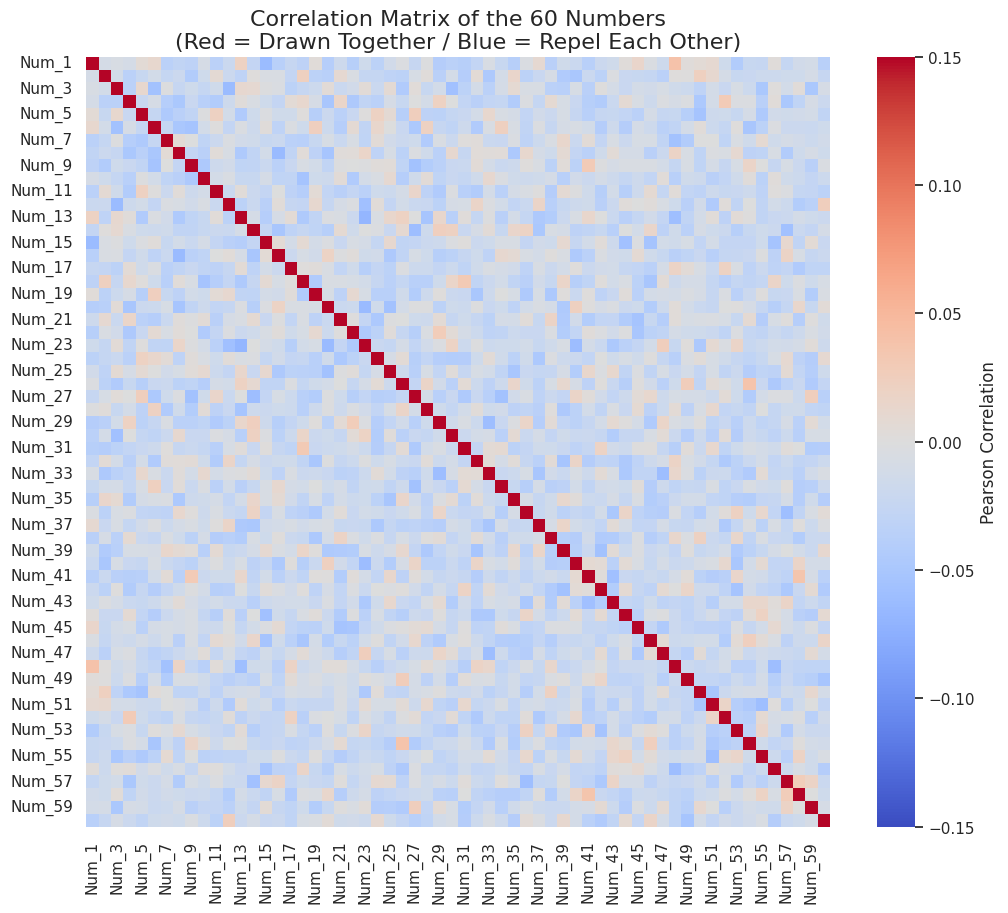

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, cmap='coolwarm', vmin=-0.15, vmax=0.15, cbar_kws={'label': 'Pearson Correlation'})
plt.title('Correlation Matrix of the 60 Numbers\n(Red = Drawn Together / Blue = Repel Each Other)', fontsize=16)
plt.show()

The predominance of neutral colors (gray/white) indicates a correlation close to zero. This is strong proof of statistical independence. The balls have no memory and do not communicate with each other.

## 6. Hypothesis Testing: Is the Game Fair? (Chi-Square)

Visuals are beautiful, but they can deceive our eyes into finding patterns where none exist. To be sure, we use Pearson's Chi-Square Test. We will compare the Observed frequency (what happened in history) with the Expected frequency (if all numbers had exactly the same chance).

- $H_0$: The game is random.
- $H_1$: The game is biased.
  
If the p-value is high (> 0.05), statistics prove: there is no biased number.

In [14]:
# Observado: Frequência real de cada número
f_obs = frequencia_total

# Esperado: Distribuição Uniforme (Total de bolas sorteadas / 60)
total_bolas = df_mega_sena.shape[0] * 6
f_exp = [total_bolas / 60] * 60

# Teste
chi2, p_valor = chisquare(f_obs=f_obs, f_exp=f_exp)

print(f"--- Chi-Square Test Results ---")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-value: {p_valor:.4f}")

--- Chi-Square Test Results ---
Chi2 Statistic: 79.26
P-value: 0.0404


In [15]:
if p_valor > 0.05:
    print("\nCONCLUSION: With 95% confidence, we DO NOT reject the null hypothesis.")
    print("This means the variations are purely a matter of chance. The game is statistically fair.")
else:
    print("\nCONCLUSION: The p-value is low. There are significant statistical deviations from perfect randomness.")


CONCLUSION: The p-value is low. There are significant statistical deviations from perfect randomness.


Running the Chi-Square Test, I had a surprise. Normally, we expect a high p-value, confirming randomness.

However, the data returned a p-value of 0.04!

In classical statistics (with a 5% cutoff), this would mean rejecting the randomness hypothesis. Does this prove the game is rigged? Not necessarily. It could be just a rare case of variance (the 'ghost' of the 5% Type I error) or a reflection of a historical sample where, by pure chance, the number 10 appeared much more than the number 60.

In any case, against the intuition that everything is equal, the data shows that the history of Mega Sena has its preferences.

### 6.1 Who are the Culprits for the Deviation?

In [16]:
# Frequência Esperada (Média)
media_esperada = total_bolas / 60

In [17]:
#Calculando o desvio (Residual)
# Positivo = Saiu mais que a média / Negativo = Saiu menos
desvios = frequencia_total - media_esperada

# Criando um DataFrame para facilitar o plot
df_desvios = pd.DataFrame({
    'Numero': range(1, 61),
    'Desvio': desvios,
    'Cor': ['Hot' if x > 0 else 'Cold' for x in desvios]
})

In [18]:
# Ordenando para pegar os extremos
df_desvios = df_desvios.sort_values(by='Desvio')

The biggest 'villain' is number 10, with a deviation of 49.
The shyest is number 26, with a deviation of -52.


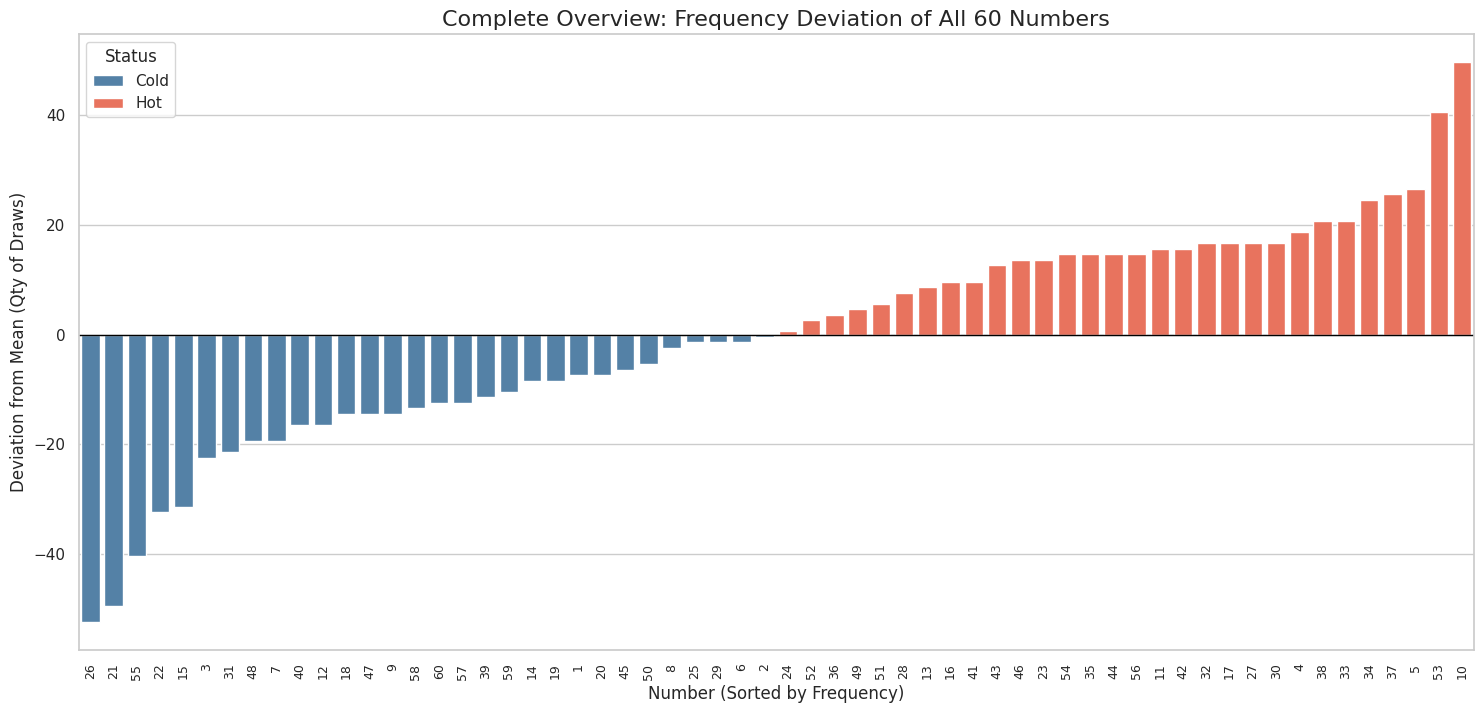

In [19]:
df_todos_ordenados = df_desvios.sort_values(by='Desvio')

df_todos_ordenados['Numero'] = df_todos_ordenados['Numero'].astype(str)

max_quente = df_todos_ordenados.iloc[-1]
max_frio = df_todos_ordenados.iloc[0]

plt.figure(figsize=(18, 8))

sns.barplot(
    data=df_todos_ordenados, 
    x='Numero', 
    y='Desvio', 
    hue='Cor', 
    dodge=False, 
    palette={'Hot': '#FF6347', 'Cold': '#4682B4'}
)

plt.axhline(0, color='black', linewidth=1)
plt.title('Complete Overview: Frequency Deviation of All 60 Numbers', fontsize=16)
plt.xlabel('Number (Sorted by Frequency)')
plt.ylabel('Deviation from Mean (Qty of Draws)')
plt.legend(title='Status')

plt.xticks(rotation=90, fontsize=9) 

print(f"The biggest 'villain' is number {int(max_quente['Numero'])}, with a deviation of {int(max_quente['Desvio'])}.")
print(f"The shyest is number {int(max_frio['Numero'])}, with a deviation of {int(max_frio['Desvio'])}.")

plt.show()

This chart explains why our statistical test pointed to an anomaly (p-value < 0.05). It is not about a bias in the whole draw, but rather the existence of Historical Outliers.

- The Extremes: We observe that a small group of numbers (the tall bars at the ends) deviates aggressively from the expected mean. They are the ones "pulling" the statistics out of the zone of perfect normality.

- Variance, not Bias: In a universe of finite random events (only ~2,700 draws), it is natural that the distribution is not a perfect straight line. What we see here is natural variance acting out: by pure chance, some numbers accumulated more appearances.

- Practical Conclusion: If the game were mechanically biased (e.g., heavier balls), we would see more systemic patterns. What we see here appears to be the noise characteristic of long-term stochastic processes.

## 7. Delay Analysis (The Gambler's Fallacy)

"Number 42 hasn't come up in a long time, it HAS to come out today!" This is the Gambler's Fallacy. Let's calculate how many contests each number has been hibernating.

In [20]:
# Calcular há quantos sorteios cada número não sai
def calcular_atraso(df, colunas_dezenas):
    ultimo_sorteio_num = df.index.max()
    atrasos = {}
    
    for num in range(1, 61):
        # Filtra os sorteios onde o número apareceu
        # (Usando a lógica booleana nas colunas)
        apareceu = (df[colunas_dezenas] == num).any(axis=1)
        if apareceu.sum() > 0:
            ultimo_indice = apareceu[apareceu].index[-1]
            atraso = ultimo_sorteio_num - ultimo_indice
        else:
            atraso = ultimo_sorteio_num # Nunca saiu (improvável com dados reais)
        atrasos[num] = atraso
            
    return pd.Series(atrasos).sort_values(ascending=False)

/tmp/ipykernel_9413/3261632018.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


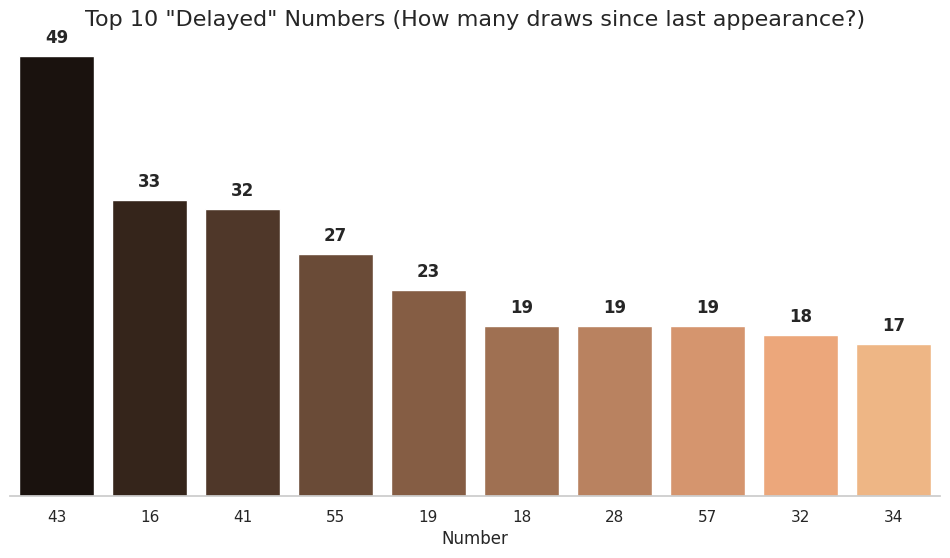

The most delayed number in current history is 43, which hasn't appeared for 49 draws.


In [21]:
atrasos_series = calcular_atraso(df_mega_sena, colunas_dezenas)
top_10_atrasados = atrasos_series.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=top_10_atrasados.index, 
    y=top_10_atrasados.values, 
    palette="copper",
    order=top_10_atrasados.index
)

plt.title('Top 10 "Delayed" Numbers (How many draws since last appearance?)', fontsize=16)
plt.xlabel('Number')
plt.ylabel('')

plt.yticks([]) # Remove os números do eixo Y
sns.despine(left=True) # Remove a linha vertical esquerda (espinha)
ax.grid(False) # Garante que não haja linhas de grade

# Adiciona o valor exato em cima da barra
for i, valor in enumerate(top_10_atrasados.values):
    plt.text(i, valor + 1, str(valor), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

mais_atrasado = top_10_atrasados.index[0]
tempo_atraso = top_10_atrasados.values[0]
print(f"The most delayed number in current history is {mais_atrasado}, which hasn't appeared for {tempo_atraso} draws.")

The chart shows numbers with gigantic delays. This proves that the "Law of Large Numbers" takes time to happen. The fact that a number is delayed does not increase the probability of it appearing in the next draw (it remains 1/60).

## 8. Quadrant Analysis (Ticket Geometry)

Many players avoid playing numbers all close together. Let's see if the draws are well spread across the 4 quadrants of the ticket.To map the "Exact Geometry" of the ticket, we must remember that the Mega Sena ticket is a matrix of 6 rows (0 to 5) by 10 columns (0 to 9). The mathematical formula to find the exact position of any number $N$ in this matrix is:
- Row: $(N - 1) // 10$ (Integer division)
- Column: $(N - 1) \% 10$ (Remainder of division)

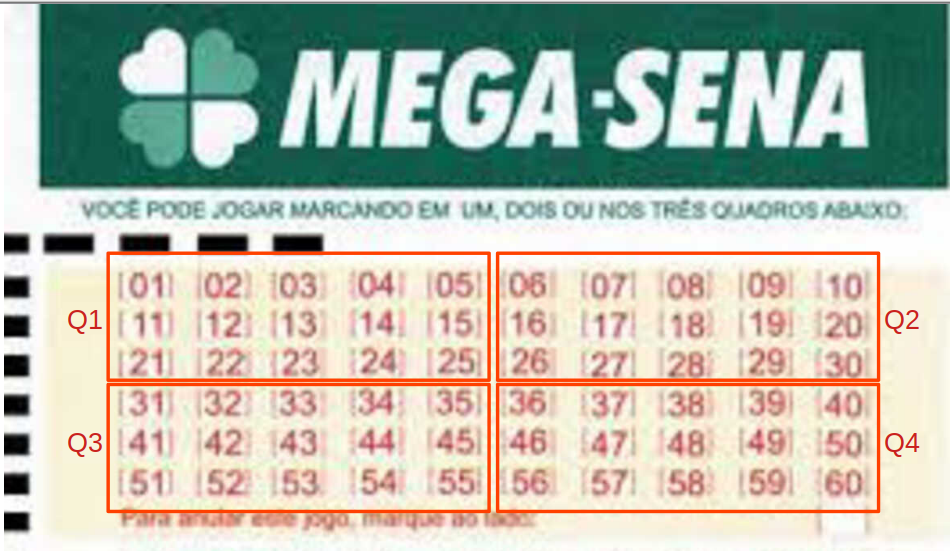

In [22]:
def classificar_quadrante_exato(num):
    """
    Mapeia a posição física exata do número no volante da Mega Sena (6x10).
    Linhas: 0 a 5 | Colunas: 0 a 9
    """
    # Matemática da matriz (0-indexed)
    linha = (num - 1) // 10 
    coluna = (num - 1) % 10
    
    # Definição EXATA das fronteiras
    # Q1 e Q2 (Metade Superior): Linhas 0, 1, 2
    # Q3 e Q4 (Metade Inferior): Linhas 3, 4, 5
    eh_superior = (linha <= 2)
    
    # Q1 e Q3 (Lado Esquerdo): Colunas 0, 1, 2, 3, 4
    # Q2 e Q4 (Lado Direito): Colunas 5, 6, 7, 8, 9
    eh_esquerda = (coluna <= 4)
    
    if eh_superior and eh_esquerda:
        return 'Q1 (Sup. Esq.)'
    elif eh_superior and not eh_esquerda:
        return 'Q2 (Sup. Dir.)'
    elif not eh_superior and eh_esquerda:
        return 'Q3 (Inf. Esq.)'
    else:
        return 'Q4 (Inf. Dir.)'

In [23]:
# Achatar todos os números de todos os sorteios em uma única lista
todos_numeros = df_mega_sena[colunas_dezenas].values.flatten()

# Aplicar a função exata
quadrantes = [classificar_quadrante_exato(n) for n in todos_numeros]

# Transformar em Série para contagem
s_quadrantes = pd.Series(quadrantes)
contagem_quadrantes = s_quadrantes.value_counts()

In [24]:
cores_quadrantes = ['#A8D5BA', '#F5D0A9', '#AEC6CF', '#FFB7B2']

In [25]:
explode = (0.05, 0.05, 0.05, 0.05) # Separa levemente as fatias para destaque

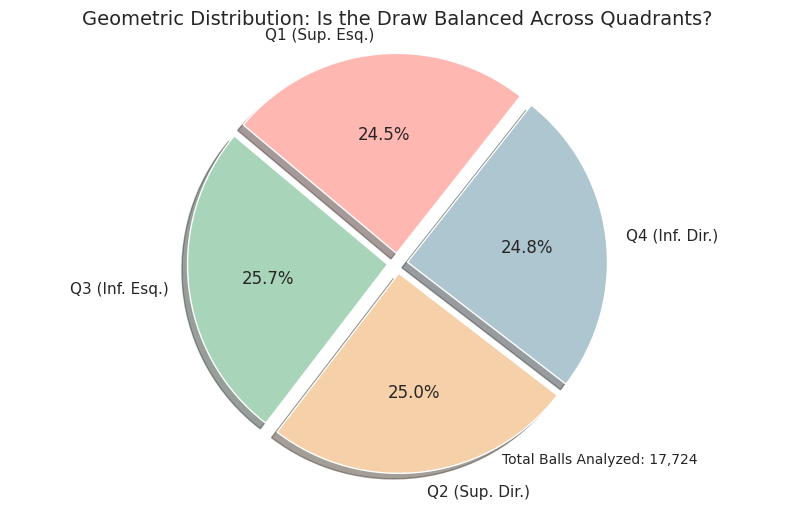

In [26]:
plt.figure(figsize=(10, 6))

plt.pie(contagem_quadrantes, 
        labels=contagem_quadrantes.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=cores_quadrantes,
        explode=explode,
        shadow=True)

plt.title('Geometric Distribution: Is the Draw Balanced Across Quadrants?', fontsize=14)
plt.axis('equal') # Garante que o pie chart seja um círculo perfeito

# Adiciona um insight textual no gráfico
plt.text(1.5, -1, f"Total Balls Analyzed: {len(todos_numeros):,}", ha='right', fontsize=10)

plt.show()

**(Almost) Perfect Balance:** The distribution hovers around 25% for each quadrant. This debunks the thesis that "the left side comes out more". To maximize your chances of not splitting the prize (if you win), avoid visual patterns, but to win, any quadrant works.

## 9. Is "Mega da Virada" different?

**Is the New Year's Draw Special?** There is a legend that during the "Virada" (New Year's Eve), the balls are different. Let's compare the average sum of the numbers in the special draws versus the rest of the year.

In [27]:
# Criar coluna de mês/dia
df_mega_sena['IsVirada'] = (df_mega_sena['Data do Sorteio'].dt.month == 12) & (df_mega_sena['Data do Sorteio'].dt.day == 31)

# Separar os datasets
df_virada = df_mega_sena[df_mega_sena['IsVirada'] == True]
df_comum = df_mega_sena[df_mega_sena['IsVirada'] == False]

In [28]:
print(f"Analisando {len(df_virada)} sorteios da Virada contra {len(df_comum)} comuns.")

Analisando 22 sorteios da Virada contra 2932 comuns.


In [29]:
# Comparar a média da soma das dezenas (apenas um exemplo)
print(f"Average Sum (New Year's): {df_virada[colunas_dezenas].sum(axis=1).mean():.2f}")
print(f"Average Sum (Regular):    {df_comum[colunas_dezenas].sum(axis=1).mean():.2f}")

Average Sum (New Year's): 183.09
Average Sum (Regular):    183.23


The difference between the averages is only 0.14 (183.09 vs 183.23). In a scale of sums that can range from 21 (1+2+3+4+5+6) to 379 (55+56+57+58+59+60), this variation is negligible. This mathematically debunks any theory that special draws use balls with different weights.

## 10. The Game Generator and Monte Carlo Validation

Predictive models in independent random events (memoryless) are, by definition, flawed. But what if we used computational brute force to test a strategy?

Next, we use the Monte Carlo Method to simulate 50,000 games betting only on the historically hottest numbers. Let's calculate the ROI (Return on Investment) and see if statistics beat luck in the long run.

In [30]:
# Definir probabilidades baseadas no histórico (pesos)
pesos = frequencia_total / frequencia_total.sum()

In [31]:
def gerar_jogo_ponderado():
    # Escolhe 6 números usando os pesos históricos
    escolha = np.random.choice(range(1, 61), size=6, replace=False, p=pesos)
    return sorted(escolha)

In [32]:
# Simulação de Monte Carlo (Investimento)
def simular_investimento(n_simulacoes=50000, seed=42):
    np.random.seed(seed) #Fixando a semente para reprodutibilidade
    custo_aposta = 6.00
    gastos = 0
    premios = 0
    
    # Define um "resultado futuro" aleatório para ser o gabarito
    gabarito = set(np.random.choice(range(1, 61), 6, replace=False))
    
    hits = []
    
    for _ in range(n_simulacoes):
        gastos += custo_aposta
        # Aqui usamos nossa estratégia ponderada para tentar ganhar
        meu_jogo = set(gerar_jogo_ponderado())
        
        acertos = len(meu_jogo.intersection(gabarito))
        hits.append(acertos)
        
        # Tabela de prêmios (considerando a previsão de R$1 bilhão para o vencedor)
        if acertos == 4: premios += 1200 #Estimado com base no histórico dos últimos sorteios da virada
        elif acertos == 5: premios += 60000 #Estimado com base no histórico dos últimos sorteios da virada
        elif acertos == 6: premios += 1000000000 # O grande prêmio
            
    return gastos, premios, hits

In [33]:
print(f"Suggested Game for the New Year's Draw (Based on Hot Numbers): {gerar_jogo_ponderado()}")

Suggested Game for the New Year's Draw (Based on Hot Numbers): [6, 7, 24, 44, 50, 58]


In [34]:
gastos, ganhos, historico_acertos = simular_investimento(50000)
roi = ((ganhos - gastos) / gastos) * 100

In [35]:
print(f"Financial Result:")
print(f"Invested: R$ {gastos:,.2f}")
print(f"Return:   R$ {ganhos:,.2f}")
print(f"ROI:       {roi:.2f}%")

Financial Result:
Invested: R$ 300,000.00
Return:   R$ 25,200.00
ROI:       -91.60%


/tmp/ipykernel_9413/3945567505.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=historico_acertos, palette="viridis")


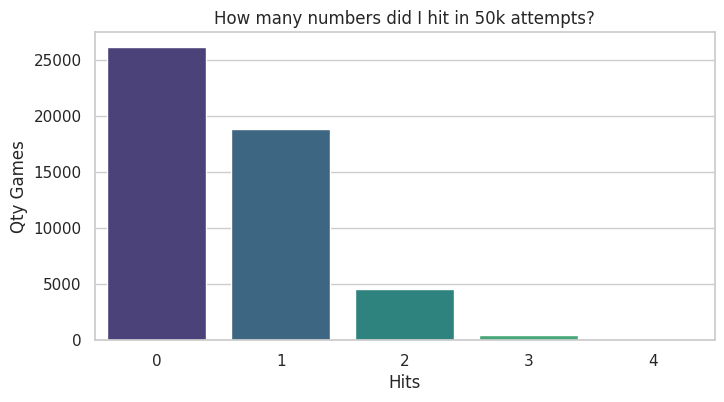

In [36]:
# Gráfico da Realidade
plt.figure(figsize=(8,4))
sns.countplot(x=historico_acertos, palette="viridis")
plt.title("How many numbers did I hit in 50k attempts?")
plt.xlabel("Hits")
plt.ylabel("Qty Games")
plt.show()

Here we find a fascinating Data Science paradox. The Chi-Square test (p=0.04) suggested that there is a statistical bias in the numbers (they are not perfectly random).

Theoretically, a Machine Learning model should exploit this bias for profit, right? Wrong.

Our simulation showed a loss of 92%. This teaches us the difference between Statistical Significance (the deviation exists in the math) and Practical Significance (the deviation is not large enough to cover the bet cost and the house edge). The pattern exists, but it is financially inoperable.

## 11. Final Conclusion: The Science Behind the Bet

We started this study with a provocative question: is it possible to hack the Mega da Virada? After analyzing over 2,000 draws, testing ticket geometry, number recurrence, and applying rigorous hypothesis tests, the data gave us a clear and humble answer.

The 3 Big Lessons:

- Randomness Rules: The Chi-Square Test and Correlation Matrices confirmed there are no "hidden patterns" or numbers that pull others. The Mega Sena is a practical example of independent events without memory.

- The Myth of the Turn: Comparative analysis proved that the "statistical signature" of the Mega da Virada (Sum Average: 183.09) is virtually identical to regular draws (Sum Average: 183.23). The balls don't know it's December 31st.

- The Gambler's Fallacy: We visualized numbers "delayed" for dozens of contests, but the Monte Carlo simulation showed that betting on them or on "hot" numbers results in the same negative ROI of 92% in the long run.

**Verdict:** Data Science serves to find patterns where there is signal, and to identify noise where there is only chaos. In the lottery, we found (almost) perfect chaos.

As a data scientist, I state: there is no winning strategy.

As a human being, I ask: does anyone want to join the pool?